# 전처리 가설 검증
- df_train + 추가데이터 전부 사용  
- 5개 나라에 대해서만 진행('칠레', '중국', '노르웨이', '태국', '베트남') > ctry_list 변수에 포함되어 있음

# Setting

In [1]:
# Import Libraries & Functions
from utility import *

In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Visualization Setting
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
# Data directory
root = os.path.join(os.getcwd(), 'DATA')

# Import Data

In [5]:
df_train = pd.read_csv(os.path.join(root, 'preprocessed_train_notencoded.csv'))
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=0, index_col=0)
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]
df_exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))

- 앞선 가설 검증에서 제공데이터 및 1차 추가 데이터에 대한 최적화가 완료되었기에 해당 data를 가져온다
- 제조국 날씨의 경우 결측치 처리 과정이 필요하기 때문에 raw data를 가져온다
- 수출국 환율의 경우 raw data를 가져온다

----

# Basic Dataframe
df_train
- 주요 국가 추출

### Dropping Data
날짜 데이터 및 환율 데이터는 특정 국가에 대해서만 수집할 수 있었다  
따라서 제조국이 '칠레', '중국', '노르웨이', '태국', '베트남'인 경우,  
그리고 수출국이 '칠레', '중국', '노르웨이', '태국', '베트남', '페루'인 경우만 다룬다

In [6]:
df_train = df_train[(
                    # 제조국
                    (df_train['CTRY_1'] == "칠레") |
                    (df_train['CTRY_1'] == "중국") |
                    (df_train['CTRY_1'] == "노르웨이") |
                    (df_train['CTRY_1'] == "태국") | 
                    (df_train['CTRY_1'] == "베트남")
                    ) & (
                    # 수출국
                    (df_train['CTRY_2'] == "칠레") |
                    (df_train['CTRY_2'] == "중국") | 
                    (df_train['CTRY_2'] == "노르웨이") |
                    (df_train['CTRY_2'] == "태국") | 
                    (df_train['CTRY_2'] == "베트남") |
                    (df_train['CTRY_2'] == "페루")
                    )]

----

# Baseline Dataframe
df_train
- one hot encoding

In [7]:
df0_base = df_train.copy()

### One hot encoding

In [8]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

## Train

Model Training Complete!


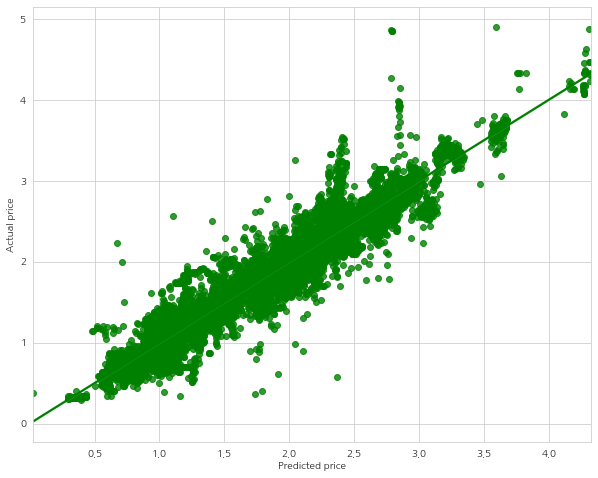

>> RMSE train = 0.20178034158408442
>> RMSE validation = 0.21534639203449177
>> MAE train = 0.13990312471904037
>> MAE validation = 0.1451043778883286
-------------------------------------------------


In [9]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

----
# Adding Weather Data
- df1_with_wf : 해안가여부 고려 없이 날씨 평균 데이터 추가
- df2_without_wf : 해안가인 지점 날씨 평균 데이터 추가

In [10]:
df1_with_wf = df_train.copy()
df2_without_wf = df_train.copy()

## Preprocess
- 이상치 제거 : 강수량과 풍속이 음수인 경우 제거
- '지점'에 따른 나라명 컬럼(CTRY_1)과 해안가여부(is_waterfront) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [11]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0]['국가명']


def set_waterfront(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty or data.iloc[0]['해안가여부'] != 1:
        return False
    return True
    

def preprocess_weather(df, drop_waterfront):
    df = df[(df['강수량'] >= 0) & (df['풍속'] >= 0)] # 이상치/결측치 제거
    set_week(df, '일시')  # 날짜 정보 처리
    
    # 1차 평균
    columns = ['year', 'week', '지점']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')
    
    # 나라명 추가
    df['CTRY_1'] = ""
    for i, row in df.iterrows():
        df.at[i, 'CTRY_1'] = set_country(row)
    
    # 해안가 여부 추가
    df['is_waterfront'] = False
    for i, row in df.iterrows():
        df.at[i, 'is_waterfront'] = set_waterfront(row)
     
    if drop_waterfront:
        df = df[df['is_waterfront']]  # 해안가가 아닌 데이터 제외
    
    # 2차 평균
    columns = ['year', 'week', 'CTRY_1']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')

    # 컬럼/행 정리
    df.drop(columns=['지점명', '지점', '강수량', '풍속', '기온', 'is_waterfront'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [12]:
weather_with_wf = []
weather_without_wf = []
for i in range(len(weather_list)):
    weather_with_wf.append(preprocess_weather(weather_list[i], False))
    weather_without_wf.append(preprocess_weather(weather_list[i], True))

In [13]:
df_weather_with_wf = pd.concat(weather_with_wf)
df_weather_without_wf = pd.concat(weather_without_wf)

### Check

In [14]:
print("=================해안가여부 고려X=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])
    print()
    
print("=================해안가여부 고려O=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])
    print()

=================해안가여부 고려X=====================
칠레 총 297 개
(2016, 5)
missing 1 values

중국 총 299 개
missing 0 values

노르웨이 총 236 개
missing 0 values

태국 총 297 개
(2016, 11)
missing 1 values

베트남 총 298 개
(2016, 6)
missing 1 values

=================해안가여부 고려O=====================
칠레 총 297 개
(2016, 5)
missing 1 values

중국 총 299 개
missing 0 values

노르웨이 총 236 개
missing 0 values

태국 총 293 개
(2016, 11)(2016, 15)(2019, 10)
missing 3 values

베트남 총 297 개
(2016, 6)
missing 1 values



### Filling Missing Values
- df_weather_with_wf : 태국, 베트남, 칠레에 결측치 1개씩
- df_weather_without_wf : 총 5개 결측치
- 결측치 > 전/차주 데이터 평균으로 채워넣기

In [15]:
def get_avg(df, year, week, country, value):
    return (df[(df['year'] == year) &
               (df['week'] == week + 1) &
               (df['CTRY_1'] == country)].iloc[0][value] 
          + df[(df['year'] == year) &
               (df['week'] == week - 1) &
               (df['CTRY_1'] == country)].iloc[0][value]) / 2

In [16]:
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_with_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])


태국 총 298 개
missing 0 values

베트남 총 299 개
missing 0 values

칠레 총 298 개
missing 0 values


In [17]:
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 15,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 15, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 15, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 15, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2019,
                                'week': 10,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2019, 10, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2019, 10, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2019, 10, '태국', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])


태국 총 296 개
missing 0 values

베트남 총 298 개
missing 0 values

칠레 총 298 개
missing 0 values


### Merge Data

In [18]:
df1_with_wf = pd.merge(df1_with_wf, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [19]:
df2_without_wf = pd.merge(df2_without_wf, df_weather_without_wf, how='left', on=['year', 'week', 'CTRY_1'])

### One hot encoding

In [20]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_with_wf = pd.get_dummies(df1_with_wf, columns=one_hot)
df2_without_wf = pd.get_dummies(df2_without_wf, columns=one_hot)

## Train

Model Training Complete!


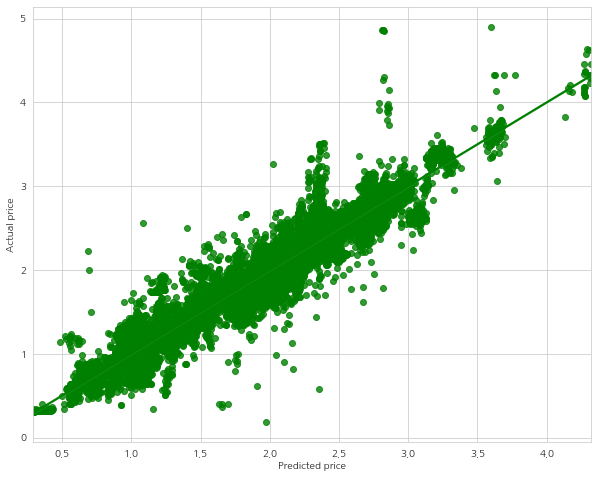

>> RMSE train = 0.20329161376553467
>> RMSE validation = 0.20860845445673648
>> MAE train = 0.1396896152581448
>> MAE validation = 0.14300160969250514
-------------------------------------------------


In [21]:
model1 = train_model(df1_with_wf.drop(columns=['P_PRICE']), df1_with_wf['P_PRICE'])

In [22]:
t1 = print_importance(model1, df1_with_wf, ['rain', 'wind', 'temperature'])

temperature : 0.03886716431413162 > 257 순위
rain : 0.0009992099166685198 > 281 순위
wind : 8.004264947120143e-05 > 286 순위
-------------------------------------------------
총 317 개


Model Training Complete!


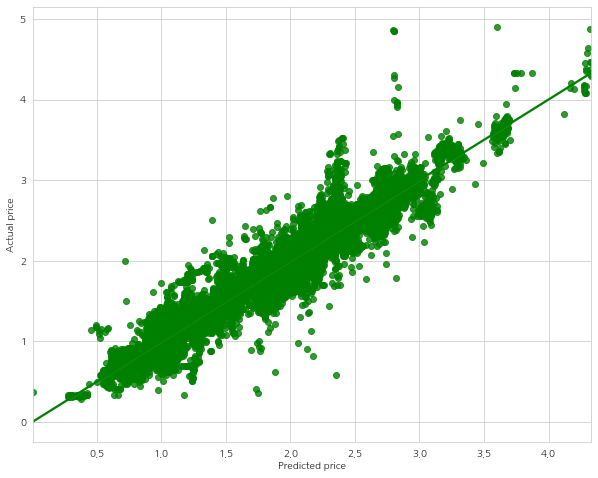

>> RMSE train = 0.1998230670247233
>> RMSE validation = 0.21798724240719716
>> MAE train = 0.13877631314989514
>> MAE validation = 0.1460983458271968
-------------------------------------------------


In [23]:
model2 = train_model(df2_without_wf.drop(columns=['P_PRICE']), df2_without_wf['P_PRICE'])

In [24]:
t2 = print_importance(model2, df2_without_wf, ['rain', 'wind', 'temperature'])

temperature : 0.09606703174956388 > 214 순위
rain : 0.0002130546342242745 > 285 순위
wind : 8.231910414108201e-05 > 287 순위
-------------------------------------------------
총 317 개


- 날씨 데이터를 추가하는 것이 모델 정확도 상승에 영향을 준다
- 해안가가 아닌 데이터를 제거하는 것은 오히려 정확도를 떨어뜨린다
- 날씨 데이터를 전부 사용한다

----
# Adding Exchange Data
- df3_add_exchange : 수출국의 환율 데이터 추가

In [25]:
df3_add_exchange = df_train.copy()

## Preprocess
### Merge Data

In [26]:
df3_add_exchange = pd.merge(df3_add_exchange, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [27]:
df3_add_exchange = pd.merge(df3_add_exchange, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

### One hot encoding

In [28]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df3_add_exchange = pd.get_dummies(df3_add_exchange, columns=one_hot)

## Train

Model Training Complete!


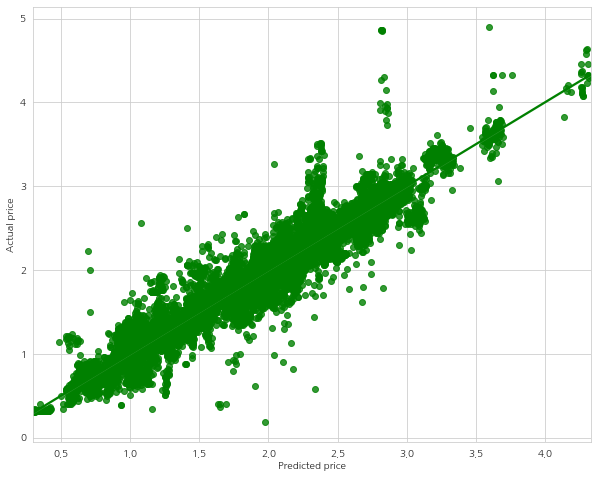

>> RMSE train = 0.20315668299863276
>> RMSE validation = 0.20859677892369408
>> MAE train = 0.1396331005394069
>> MAE validation = 0.1428509706541048
-------------------------------------------------


In [29]:
model3 = train_model(df3_add_exchange.drop(columns=['P_PRICE']), df3_add_exchange['P_PRICE'])

In [30]:
t3 = print_importance(model3, df3_add_exchange, ['exchange'])

exchange : 0.03577336157071874 > 260 순위
-------------------------------------------------
총 318 개


- 미세하게 모델 정확도가 상승하였으므로 환율 데이터도 사용하도록 한다

----
# Scaling
Feature scaling is not important for algorithms such as random forest or decision tree 
- Standardization
- Normalization

In [112]:
sc = StandardScaler()

In [113]:
df4_scaling = df_train.copy()

## Preprocess
### Merge Data

In [114]:
df4_scaling = pd.merge(df4_scaling, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [115]:
df4_scaling = pd.merge(df4_scaling, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

#### wind

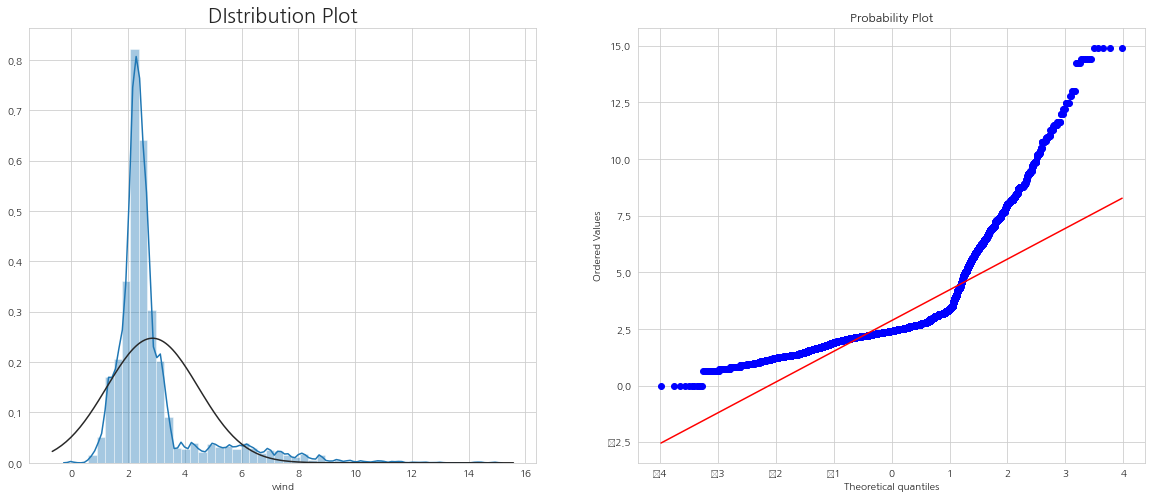

In [116]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [117]:
# Log Transformation
df4_scaling['wind'] = np.log1p(df4_scaling['wind'])

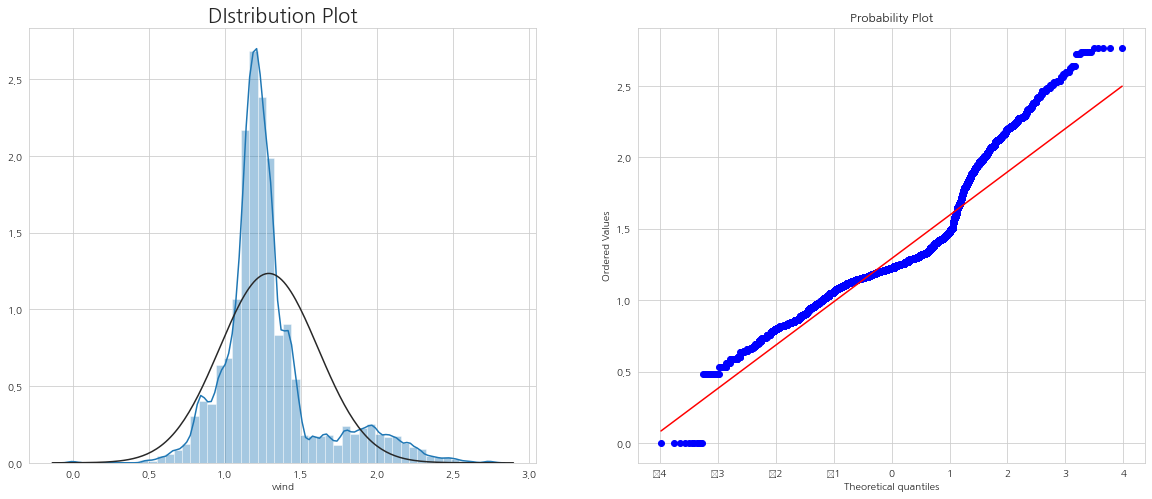

In [118]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['wind'], plot=plt)

plt.show()

In [119]:
# Normalization
df4_scaling[['wind']] = sc.fit_transform(df4_scaling[['wind']])

#### rain

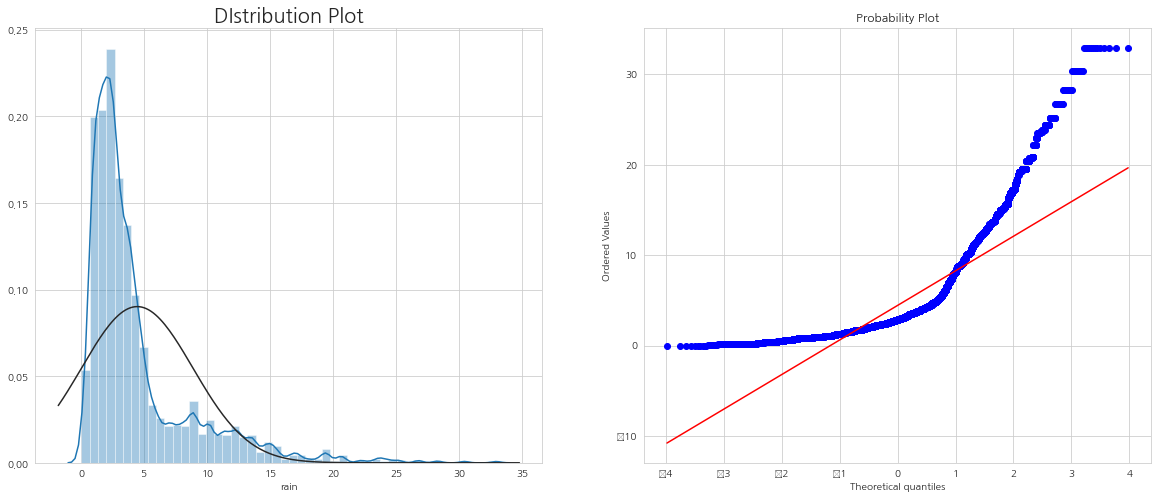

In [120]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [121]:
# Log Transformation
df4_scaling['rain'] = np.log1p(df4_scaling['rain'])

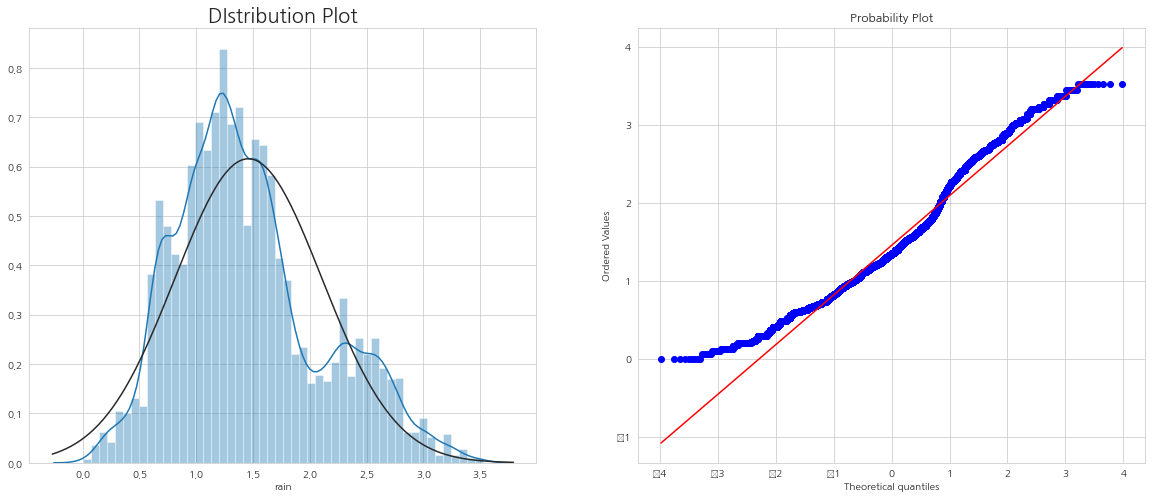

In [122]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['rain'], plot=plt)

plt.show()

In [123]:
# Standardization
df4_scaling[['rain']] = sc.fit_transform(df4_scaling[['rain']])

#### temperature

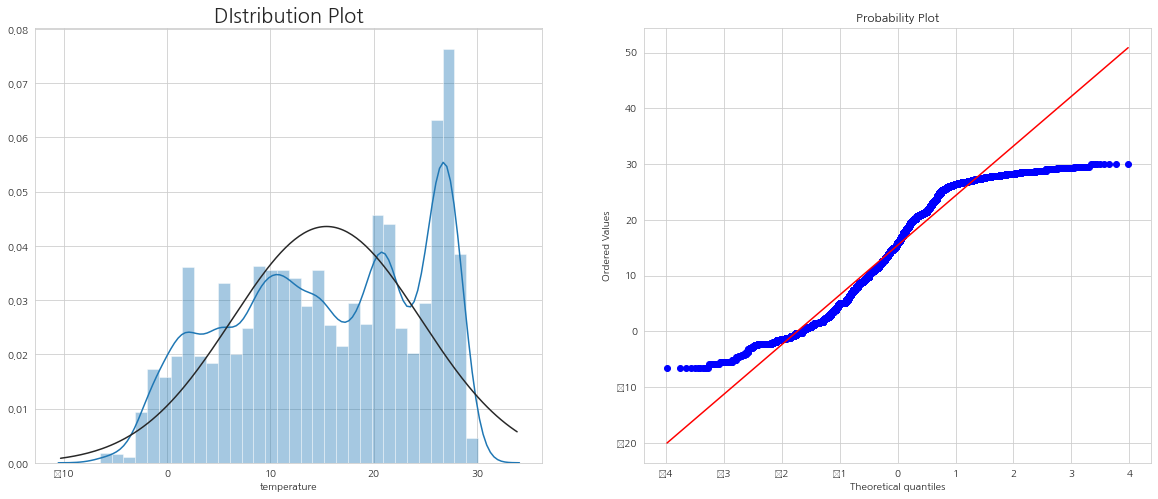

In [124]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['temperature'], plot=plt)

plt.show()

In [125]:
df4_scaling[['temperature']] = sc.fit_transform(df4_scaling[['temperature']])

#### exchange

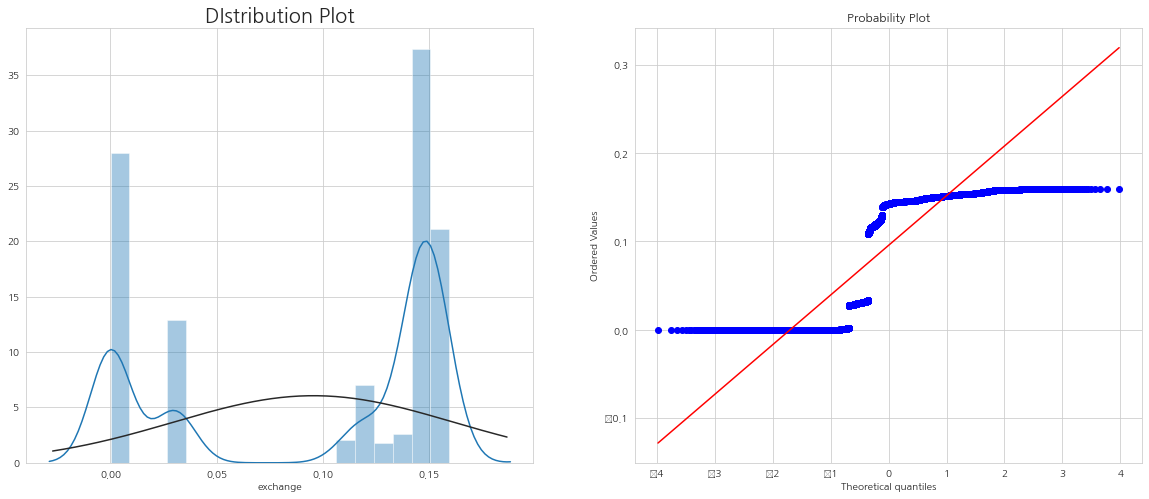

In [126]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_scaling['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_scaling['exchange'], plot=plt)

plt.show()

In [127]:
df4_scaling[['exchange']] = sc.fit_transform(df4_scaling[['exchange']])

### 기타
기타 numerical feature 에 대해서도 진행한다

In [108]:
columns = ['P_PRICE', 'ctry1_cnt', 'purpose_cnt', 'category1_cnt', 'category2_cnt', 'name_cnt', 'import_cnt',
           'wind_kr', 'cpi_total', 'temp_kr']
df4_scaling[columns] = sc.fit_transform(df4_scaling[columns])


### One hot encoding

In [128]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df4_scaling = pd.get_dummies(df4_scaling, columns=one_hot)

## Train

Model Training Complete!


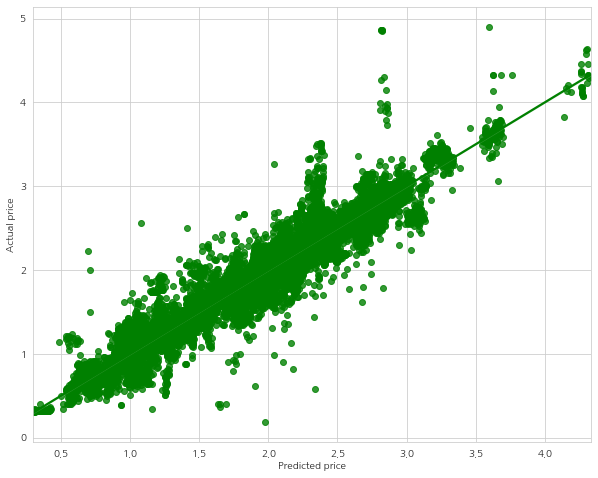

>> RMSE train = 0.20315246560499062
>> RMSE validation = 0.2086017249218532
>> MAE train = 0.13963601807086556
>> MAE validation = 0.14286448560968223
-------------------------------------------------


In [129]:
model4 = train_model(df4_scaling.drop(columns=['P_PRICE']), df4_scaling['P_PRICE'])

In [130]:
t4 = print_importance(model4, df4_scaling, [])

-------------------------------------------------
총 318 개


----
# Feature Selection

In [144]:
df5_fs = df_train.copy()

## Preprocess
### Merge Data

In [145]:
df5_fs = pd.merge(df5_fs, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [146]:
df5_fs = pd.merge(df5_fs, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [147]:
df5_fs.columns

Index(['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME',
       'P_PRICE', 'year', 'week', 'ctry1_cnt', 'purpose_cnt', 'category1_cnt',
       'category2_cnt', 'name_cnt', 'is_processed', 'import_cnt', '창난', '개아지살',
       '건조', '냉동', '집게다리', '절단', '내장', '알', '지느러미', '외투막', '훈제', '자숙', '살',
       '냉장', '볼살', '껍질', '꼬리_외화획득용', '동체', '다리', '난포선', '턱살', '슬라이스(S)',
       '포장횟감', '줄기', '염장', '한쪽껍질붙은', '횟감', '머리살', '캐비아대용', '머리_외화획득용', '목살',
       '활', '필렛(F)', '간', '곤이', '눈살', '머리', 'oil', 'wind_kr', 'cpi_total',
       'temp_kr', 'rain', 'wind', 'temperature', 'exchange'],
      dtype='object')

In [148]:
df5_fs['wind'] = np.log1p(df5_fs['wind'])
df5_fs['rain'] = np.log1p(df5_fs['rain'])
df5_fs['exchange'] = np.log1p(df5_fs['exchange'])

df5_fs[['temp_kr']] = sc.fit_transform(df5_fs[['temp_kr']])
df5_fs[['wind_kr']] = sc.fit_transform(df5_fs[['wind_kr']])
df5_fs[['oil']] = sc.fit_transform(df5_fs[['oil']])
df5_fs[['rain']] = sc.fit_transform(df5_fs[['rain']])
df5_fs[['wind']] = sc.fit_transform(df5_fs[['wind']])
df5_fs[['temperature']] = sc.fit_transform(df5_fs[['temperature']])

In [149]:
df5_fs['weather_kr'] = (df5_fs['temp_kr'] + df5_fs['wind_kr']) / 2
df5_fs['weather'] = (df5_fs['temperature'] + df5_fs['rain'] + df5_fs['wind']) / 3

df5_fs.drop(['temp_kr','wind_kr','oil'],axis=1,inplace=True)

df5_fs = df5_fs.set_index(['year','week'])

### One hot encoding

In [151]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df5_fs = pd.get_dummies(df5_fs, columns=one_hot)

Model Training Complete!


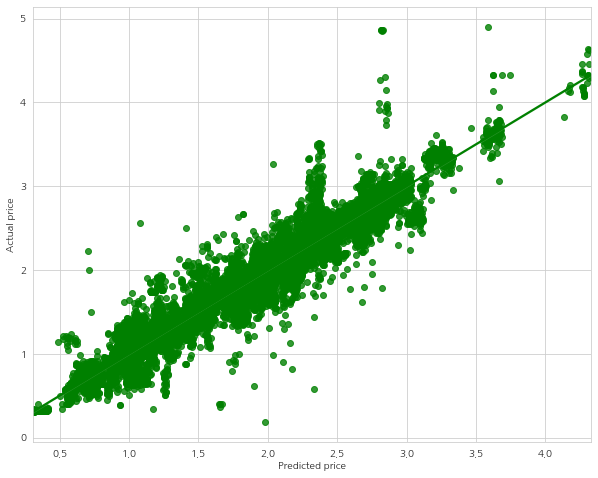

>> RMSE train = 0.20326915724259503
>> RMSE validation = 0.20884942646256366
>> MAE train = 0.13968333555623239
>> MAE validation = 0.14298824686549186
-------------------------------------------------


In [152]:
model5 = train_model(df5_fs.drop(columns=['P_PRICE']), df5_fs['P_PRICE'])

# Final

In [25]:
df_final = df_train.copy()

## Preprocess
### Merge Data

In [26]:
df3_add_exchange = pd.merge(df3_add_exchange, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [27]:
df3_add_exchange = pd.merge(df3_add_exchange, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

### One hot encoding

In [28]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df3_add_exchange = pd.get_dummies(df3_add_exchange, columns=one_hot)

## Train

Model Training Complete!


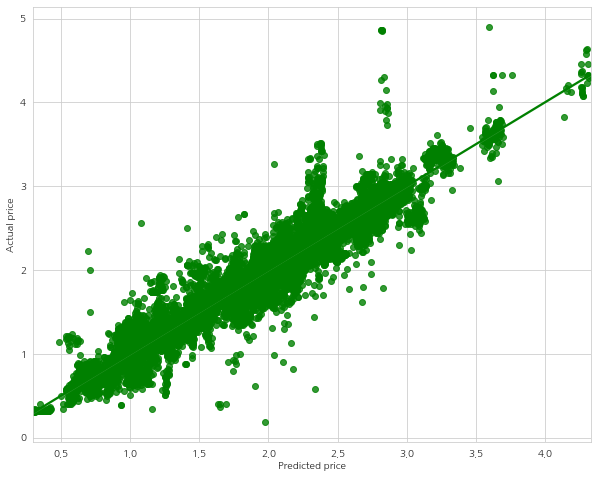

>> RMSE train = 0.20315668299863276
>> RMSE validation = 0.20859677892369408
>> MAE train = 0.1396331005394069
>> MAE validation = 0.1428509706541048
-------------------------------------------------


In [29]:
model3 = train_model(df3_add_exchange.drop(columns=['P_PRICE']), df3_add_exchange['P_PRICE'])